<a href="https://colab.research.google.com/github/mickeyrahm/Portfolio/blob/master/notebooks/starter_signs_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [2]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.

from tensorflow.keras.preprocessing.image import ImageDataGenerator


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    brightness_range=[0.2, 1.0],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [3]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Priority', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'General Danger(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Double_Curve', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Ice_Snow', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

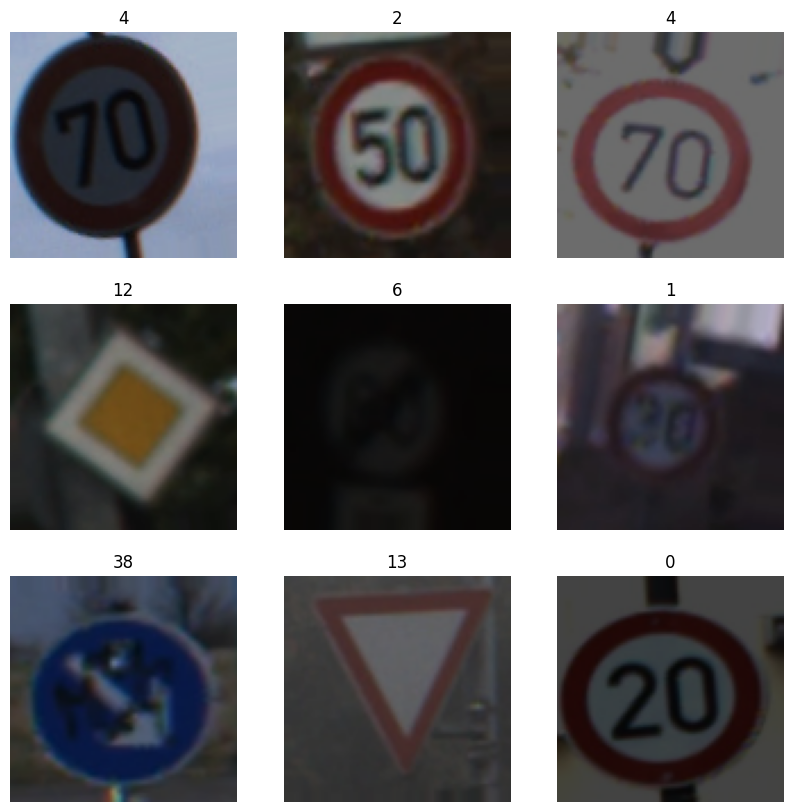

In [4]:
import matplotlib.pyplot as plt


# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score

# Define the model
def build_best_model():
    model = Sequential()

    # First Conv block
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(100, 100, 3)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    # Second Conv block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# Build and train the model
best_model = build_best_model()

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = best_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stop]
)

# Predict on the full validation set
all_preds = []
all_labels = []

for i in range(len(validation_generator)):
    images, labels = validation_generator[i]
    preds = best_model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    all_preds.extend(pred_classes)
    all_labels.extend(labels)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Map class indices to names
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Classification metrics
print(classification_report(all_labels, all_preds, target_names=list(idx_to_class.values())))

f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')

print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Visualize predictions from the first batch
images, labels = validation_generator[0]
preds = best_model.predict(images)
pred_classes = np.argmax(preds, axis=1)

for i in range(5):
    plt.imshow(images[i])
    plt.title(f"Predicted: {idx_to_class[pred_classes[i]]}\nActual: {idx_to_class[int(labels[i])]}")
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 123s 121ms/step - accuracy: 0.2541 - loss: 2.6604 - val_accuracy: 0.4552 - val_loss: 1.7339
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.4701 - loss: 1.6263 - val_accuracy: 0.5061 - val_loss: 1.7077
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.5813 - loss: 1.2423 - val_accuracy: 0.6791 - val_loss: 1.0830
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.7326 - loss: 0.8176 - val_accuracy: 0.8264 - val_loss: 0.5989
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 114s 116ms/step - accuracy: 0.8047 - loss: 0.5882 - val_accuracy: 0.8658 - val_loss: 0.4199
Epoch 6/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.8515 - loss: 0.4481 - val_accuracy: 0.8925 - val_loss: 0.3971
Epoch 7/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 115s 118ms/step - accuracy: 0.8796 - loss: 0.3756 - val_accuracy: 0.8904 - val_loss: 0.3889
Epoch 8/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 145s 120ms/step - accuracy: 0.8893 -

In [ ]:
import coremltools as ct

# Save the Keras model (if not already saved)
best_model.save("traffic_sign_model.h5")

# Convert the model to Core ML
mlmodel = ct.convert(
    "traffic_sign_model.h5",
    source="tensorflow",
    inputs=[ct.ImageType(shape=(1, 100, 100, 3), scale=1/255.0)]
)

# Save the Core ML model
mlmodel.save("TrafficSignClassifier.mlmodel")


<Figure size 2000x1000 with 0 Axes>

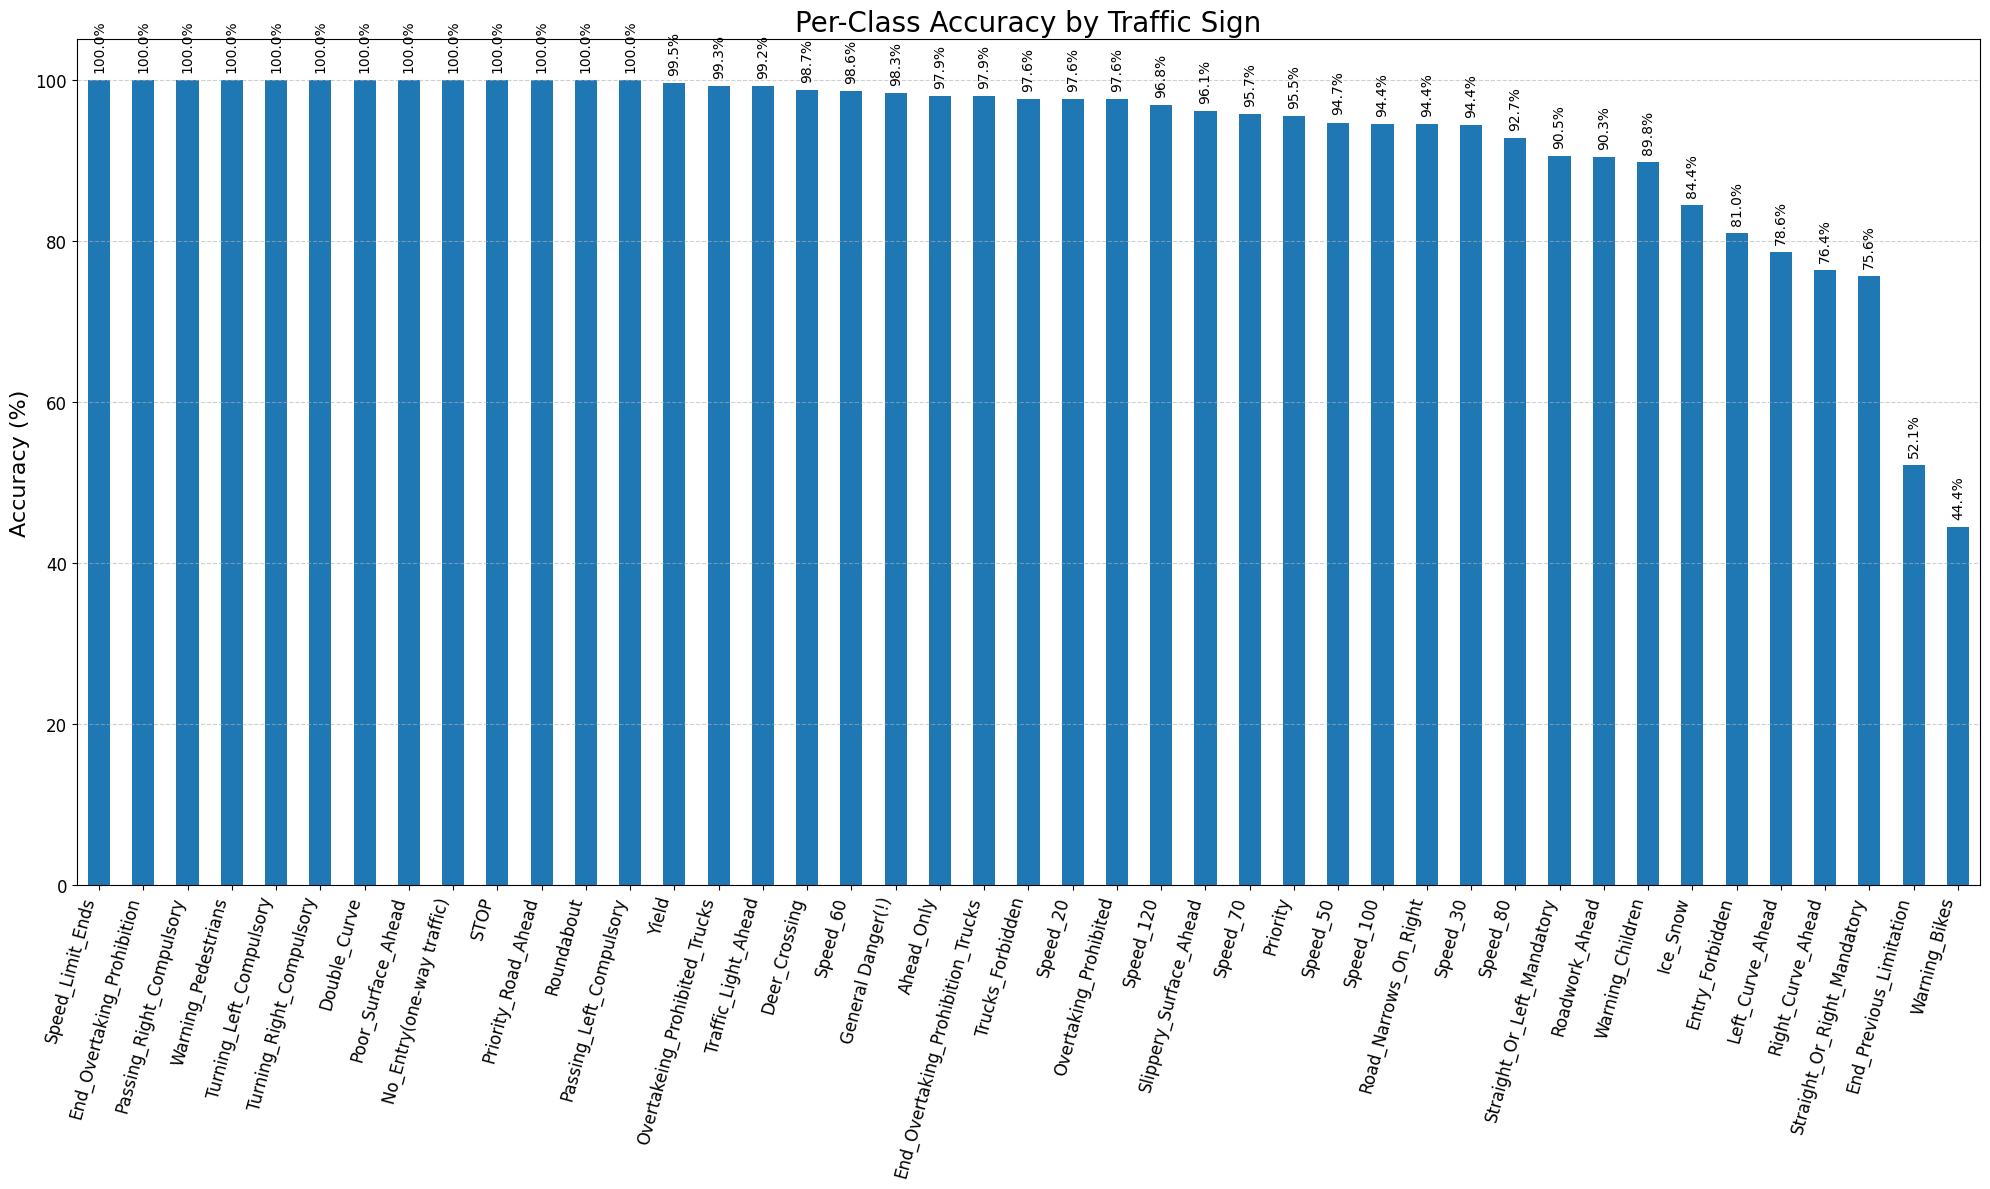

In [20]:
per_class_accuracy = {}

for class_index in np.unique(all_labels):
    class_name = target_names[int(class_index)]
    mask = all_labels == class_index
    acc = accuracy_score(all_labels[mask], all_preds[mask])
    per_class_accuracy[class_name] = acc * 100

acc_df = pd.DataFrame.from_dict(per_class_accuracy, orient='index', columns=['Accuracy (%)'])
acc_df = acc_df.sort_values(by='Accuracy (%)', ascending=False)

# Plot
plt.figure(figsize=(20, 10))
ax = acc_df.plot(kind='bar', legend=False, figsize=(20, 14))
plt.ylabel('Accuracy (%)', fontsize=16)
plt.title('Per-Class Accuracy by Traffic Sign', fontsize=20)
plt.xticks(rotation=75, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add accuracy labels above bars
for i, value in enumerate(acc_df['Accuracy (%)']):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', va='bottom', fontsize=10, rotation=90)

plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Load true labels and rename columns
answers_df = pd.read_csv('/content/mini_holdout_answers.csv')
answers_df.rename(columns={'Filename': 'filename', 'ClassId': 'label'}, inplace=True)

# Prepare test data
test_dir = '/content/'
image_size = (100, 100)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=['mini_holdout'],         # folder should be /content/mini_holdout
    target_size=image_size,
    class_mode='sparse',
    shuffle=False
)

# Run predictions
probabilities = best_model.predict(test_generator)
predictions = np.argmax(probabilities, axis=1)
filenames = [f.split('/')[-1] for f in test_generator.filenames]

# Create DataFrame of predictions
pred_df = pd.DataFrame({
    'filename': filenames,
    'predicted_class': predictions
})

# Merge predictions with ground truth
merged_df = pd.merge(answers_df, pred_df, on='filename')

# Add 'correct' column
merged_df['correct'] = merged_df['label'] == merged_df['predicted_class']
num_correct = merged_df['correct'].sum()
total = len(merged_df)
print(f"Correct Predictions: {num_correct}/{total} ({num_correct / total:.2%})")

# Compute metrics
y_true = merged_df['label']
y_pred = merged_df['predicted_class']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Save results
merged_df.to_csv('/content/predictions_with_answers.csv', index=False)

Found 201 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Correct Predictions: 191/201 (95.02%)

Accuracy: 0.9502
F1 Score (weighted): 0.9478
Precision (weighted): 0.9620
Recall (weighted): 0.9502

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.91      0.95        11
           2       0.89      1.00      0.94         8
           3       1.00      0.80      0.89        10
           4       1.00      1.00      1.00         9
           5       0.71      1.00      0.83         5
           6       1.00      1.00      1.00         3
           7       0.89      1.00      0.94         8
           8       1.00      0.83      0.91         6
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        12
          11       0.80      1.00      0.89         8
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.0

Loading: /content/mini_holdout/00093.jpg


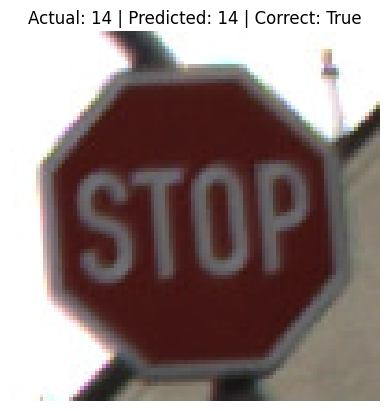

Loading: /content/mini_holdout/00111.jpg


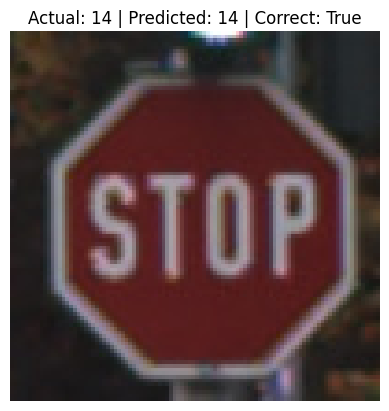

Loading: /content/mini_holdout/00132.jpg


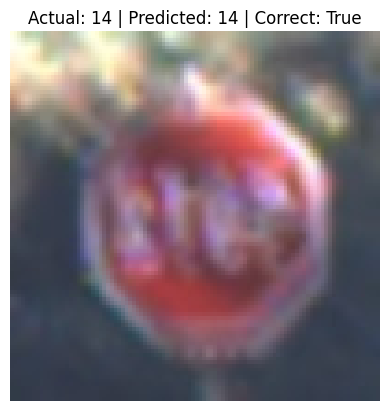

Loading: /content/mini_holdout/00167.jpg


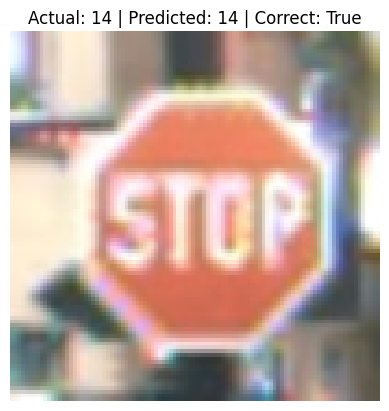

In [7]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img

# Set target class to inspect
target_class = 14  # change as needed

# Filter all examples with this true label
subset = merged_df[merged_df['label'] == target_class]

# Display up to 10 images
for i, row in subset.head(10).iterrows():
    img_path = os.path.join(test_dir, 'mini_holdout', row['filename'])
    print(f"Loading: {img_path}")
    if not os.path.exists(img_path):
        print("File not found.")
        continue
    img = load_img(img_path, target_size=image_size)
    plt.imshow(img)
    plt.title(f"Actual: {row['label']} | Predicted: {row['predicted_class']} | Correct: {row['correct']}")
    plt.axis('off')
    plt.show()


## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```